# Q-diamond plot

#### --- qiskit integration - initialization of states ---

(authored by JK, AC Sep 28th, 2025)

This plotting routinge displays a n-qubit quantum state as a Hasse-type diagram with embedded probabilities. This is useful to debug algorithmic snippets of quantum circuits analytically.

In [1]:
import qmond_lib as qd
import matplotlib.pyplot as plt
%matplotlib inline

##### Conversion routing follows in the next cell. Note that this should ideally be in the Python library as already prepared, yet something's wrong with the Python environment at this point in time.

In [2]:
import numpy as np
from typing import Dict, Tuple, Iterable, Union

def probs_dict_to_subset_dict(probs_dict: Dict[str, float]) -> Dict[Tuple[int, ...], float]:
    """
    Convert Qiskit's probabilities_dict (bitstring keys) to a subset→value dict.

    Example: {"00": 0.5, "11": 0.5}  →  {(): 0.5, (0,1): 0.5}
    """
    out = {}
    for bitstring, p in probs_dict.items():
        n = len(bitstring)
        # Reverse order: bitstring[-1] = qubit 0, bitstring[-2] = qubit 1, etc.
        subset = tuple(i for i, bit in enumerate(reversed(bitstring)) if bit == "1")
        out[subset] = p
    return out

Subset = Tuple[int, ...]
AmpDict = Dict[Subset, complex]

def statevector_to_subset_dict(state: Union["Statevector", np.ndarray, Iterable[complex]],
                               eps: float = 0.0) -> AmpDict:
    """
    Convert a Qiskit Statevector (or 1D complex iterable) into a dict that maps
    'subset of qubit indices that are 1' -> complex amplitude.

    - Bit convention: bit j corresponds to qubit j (qubit 0 is least significant).
    - If eps > 0, amplitudes with |a| <= eps are dropped.
    """
    # Extract flat complex array
    if isinstance(state, Statevector):
        vec = np.asarray(state.data, dtype=complex)
        n = int(round(np.log2(vec.size)))
    else:
        vec = np.asarray(state, dtype=complex).ravel()
        n = int(round(np.log2(vec.size)))

    if vec.size != (1 << n):
        raise ValueError("Input length is not a power of two; expected a qubit statevector.")

    out: AmpDict = {}
    for i, a in enumerate(vec):
        if abs(a) <= eps:
            continue
        # subset = indices of qubits that are 1 in the basis state |b_{n-1} ... b_1 b_0>
        subset = tuple(j for j in range(n) if (i >> j) & 1)
        out[subset] = a
    return out

#### Integration with QisKit

In [8]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import StatePreparation
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator

import numpy as np
from math import ceil, log2

def _num_qubits_for_length(m: int) -> int:
    """Smallest n with 2**n >= m."""
    return max(1, ceil(log2(max(1, m))))

def _pad_to_power_two(vec: np.ndarray, length: int) -> np.ndarray:
    """Right-pad to given length with zeros."""
    if len(vec) > length:
        raise ValueError("Target length smaller than data length.")
    out = np.zeros(length, dtype=complex)
    out[:len(vec)] = vec.astype(complex)
    return out

def amplitude_encoding(x: np.ndarray) -> QuantumCircuit:
    """
    Amplitude-encode a real vector x into |ψ> = sum_i (x_i / ||x||) |i>.
    Unused computational-basis states (to reach power-of-two) get amplitude 0.
    """
    if np.allclose(x, 0):
        raise ValueError("Amplitude encoding needs a non-zero vector.")
    n = _num_qubits_for_length(len(x))
    dim = 2**n

    # Normalize magnitudes; phases set to zero implicitly by using real positives/negatives in x
    amp = x / np.linalg.norm(x)
    amp = _pad_to_power_two(amp, dim)

    qc = QuantumCircuit(n, name="AmplitudeEncoding")
    qc.append(StatePreparation(amp), qc.qubits)
    return qc

def phase_encoding(x: np.ndarray, phase_scale: float = 1.0) -> QuantumCircuit:
    """
    Phase-encode a real vector x into |ψ> where:
      - First len(x) basis states have equal magnitude 1/sqrt(len(x))
      - Their phases carry the data: amplitude_i = exp(i * phase_scale * x_i) / sqrt(len(x))
      - Remaining basis states have amplitude 0
    """
    m = len(x)
    n = _num_qubits_for_length(m)
    dim = 2**n

    # Equal magnitude on first m entries, phases from x
    base_mag = 1.0 / np.sqrt(m)
    amps = np.zeros(dim, dtype=complex)
    amps[:m] = np.exp(1j * phase_scale * x) * base_mag

    qc = QuantumCircuit(n, name="PhaseEncoding")
    qc.append(StatePreparation(amps), qc.qubits)
    return qc


(<Figure size 1200x600 with 12 Axes>,
 <Axes: title={'center': 'phase encoding - imag'}>)

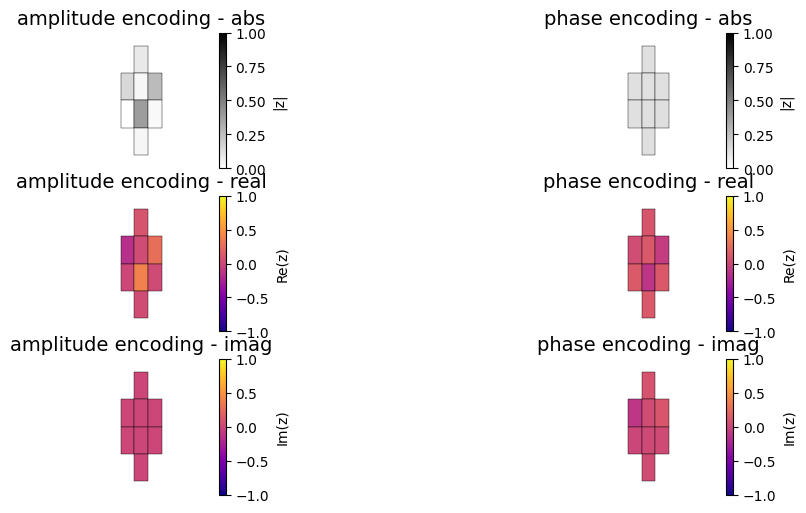

In [10]:
number_of_qubits = 3
# 5-dim real vector (feel free to change values)
x = np.array([0.7, -1.2, 0.3, 0.0, 2.1, 3.0, 0.2, 0.3], dtype=float)

# Build circuits
qc_amp  = amplitude_encoding(x)
qc_amp_sv = Statevector.from_instruction(qc_amp)
prob_dict_amp = statevector_to_subset_dict(qc_amp_sv) 
#print("Amplitude-encoding circuit:")
#print(qc_amp.draw())

qc_phase = phase_encoding(x, phase_scale=1.0)  # set scale to compress/expand phases
qc_phase_sv = Statevector.from_instruction(qc_phase)
prob_dict_phase = statevector_to_subset_dict(qc_phase_sv) 
#print("\nPhase-encoding circuit:")
#print(qc_phase.draw())

h_spacing = 0.5
v_spacing = 1.0
size = [h_spacing, v_spacing]

fig, axes = plt.subplots(3, 2, figsize=(12, 6))

comp = "abs"

qd.plot_qbit_space(
    n = number_of_qubits,   
    prob = prob_dict_amp,
    prob_component = comp,
    fig=fig, ax=axes[0,0],
    title = "amplitude encoding - abs",
    tensor_bs_size = size,
    horizontal_spacing = h_spacing,
    vertical_spacing = v_spacing
)

qd.plot_qbit_space(
    n = number_of_qubits,   
    prob = prob_dict_phase,
    prob_component = comp,
    fig=fig, ax=axes[0,1],
    title = "phase encoding - abs",
    tensor_bs_size = size,
    horizontal_spacing = h_spacing,
    vertical_spacing = v_spacing
)

comp = "real"

qd.plot_qbit_space(
    n = number_of_qubits,   
    prob = prob_dict_amp,
    prob_component = comp,
    fig=fig, ax=axes[1,0],
    title = "amplitude encoding - real",
    tensor_bs_size = size,
    horizontal_spacing = h_spacing,
    vertical_spacing = v_spacing
)

qd.plot_qbit_space(
    n = number_of_qubits,   
    prob = prob_dict_phase,
    prob_component = comp,
    fig=fig, ax=axes[1,1],
    title = "phase encoding - real",
    tensor_bs_size = size,
    horizontal_spacing = h_spacing,
    vertical_spacing = v_spacing
)

comp = "imag"

qd.plot_qbit_space(
    n = number_of_qubits,   
    prob = prob_dict_amp,
    prob_component = comp,
    fig=fig, ax=axes[2,0],
    title = "amplitude encoding - imag",
    tensor_bs_size = size,
    horizontal_spacing = h_spacing,
    vertical_spacing = v_spacing
)

qd.plot_qbit_space(
    n = number_of_qubits,   
    prob = prob_dict_phase,
    prob_component = comp,
    fig=fig, ax=axes[2,1],
    title = "phase encoding - imag",
    tensor_bs_size = size,
    horizontal_spacing = h_spacing,
    vertical_spacing = v_spacing
)